In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "vlim"
z_range = "all_z"
key = "z"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  6.68it/s]

9it [00:00,  9.21it/s]

18it [00:00, 12.59it/s]

27it [00:00, 16.92it/s]

34it [00:00, 21.63it/s]

47it [00:00, 28.78it/s]

59it [00:00, 37.17it/s]

72it [00:00, 47.02it/s]

85it [00:00, 58.14it/s]

98it [00:01, 69.56it/s]

111it [00:01, 80.75it/s]

124it [00:01, 90.05it/s]

138it [00:01, 99.19it/s]

152it [00:01, 106.87it/s]

165it [00:01, 112.70it/s]

179it [00:01, 117.30it/s]

192it [00:01, 120.83it/s]

205it [00:01, 121.35it/s]

218it [00:02, 123.47it/s]

231it [00:02, 104.45it/s]

244it [00:02, 110.73it/s]

258it [00:02, 115.94it/s]

271it [00:02, 118.06it/s]

284it [00:02, 108.39it/s]

296it [00:02, 98.48it/s] 

307it [00:02, 94.56it/s]

317it [00:03, 91.94it/s]

327it [00:03, 90.54it/s]

338it [00:03, 95.38it/s]

351it [00:03, 102.06it/s]

362it [00:03, 95.93it/s] 

374it [00:03, 100.83it/s]

387it [00:03, 107.26it/s]

400it [00:03, 112.86it/s]

413it [00:03, 116.46it/s]

425it [00:04, 116.70it/s]

438it [00:04, 120.21it/s]

452it [00:04, 123.19it/s]

466it [00:04, 125.69it/s]

479it [00:04, 126.11it/s]

492it [00:04, 125.24it/s]

505it [00:04, 116.08it/s]

518it [00:04, 118.75it/s]

532it [00:04, 122.12it/s]

545it [00:04, 123.87it/s]

558it [00:05, 125.01it/s]

571it [00:05, 126.44it/s]

585it [00:05, 125.25it/s]

598it [00:05, 119.84it/s]

611it [00:05, 122.48it/s]

624it [00:05, 123.97it/s]

637it [00:05, 124.12it/s]

650it [00:05, 121.75it/s]

663it [00:05, 122.71it/s]

676it [00:06, 123.68it/s]

689it [00:06, 124.72it/s]

702it [00:06, 123.45it/s]

715it [00:06, 120.65it/s]

728it [00:06, 122.85it/s]

741it [00:06, 120.54it/s]

754it [00:06, 122.59it/s]

767it [00:06, 121.95it/s]

780it [00:06, 123.96it/s]

793it [00:06, 124.29it/s]

806it [00:07, 123.78it/s]

819it [00:07, 124.97it/s]

832it [00:07, 125.68it/s]

845it [00:07, 126.09it/s]

858it [00:07, 124.03it/s]

871it [00:07, 124.69it/s]

884it [00:07, 124.46it/s]

897it [00:07, 125.35it/s]

910it [00:07, 125.74it/s]

923it [00:08, 114.89it/s]

935it [00:08, 114.90it/s]

948it [00:08, 118.32it/s]

962it [00:08, 121.39it/s]

975it [00:08, 123.29it/s]

989it [00:08, 125.60it/s]

1002it [00:08, 108.40it/s]

1015it [00:08, 113.36it/s]

1028it [00:08, 117.17it/s]

1041it [00:09, 118.99it/s]

1054it [00:09, 121.34it/s]

1067it [00:09, 122.55it/s]

1080it [00:09, 124.18it/s]

1093it [00:09, 124.15it/s]

1106it [00:09, 125.50it/s]

1119it [00:09, 126.38it/s]

1132it [00:09, 126.59it/s]

1145it [00:09, 127.27it/s]

1159it [00:09, 128.74it/s]

1172it [00:10, 128.96it/s]

1185it [00:10, 124.60it/s]

1198it [00:10, 124.59it/s]

1211it [00:10, 121.19it/s]

1224it [00:10, 122.78it/s]

1237it [00:10, 124.09it/s]

1250it [00:10, 113.59it/s]

1263it [00:10, 116.80it/s]

1276it [00:10, 119.60it/s]

1289it [00:11, 102.36it/s]

1302it [00:11, 108.41it/s]

1315it [00:11, 112.82it/s]

1328it [00:11, 116.84it/s]

1340it [00:11, 114.95it/s]

1353it [00:11, 118.76it/s]

1366it [00:11, 120.43it/s]

1379it [00:11, 122.44it/s]

1393it [00:11, 124.59it/s]

1406it [00:12, 125.36it/s]

1419it [00:12, 125.95it/s]

1432it [00:12, 126.05it/s]

1440it [00:12, 116.86it/s]


0it [00:00, ?it/s]

14it [00:00, 132.50it/s]

Number of empty sat catalogs is 0


27it [00:00, 131.32it/s]

41it [00:00, 131.68it/s]

55it [00:00, 131.56it/s]

67it [00:00, 127.55it/s]

81it [00:00, 129.63it/s]

93it [00:00, 116.45it/s]

104it [00:00, 107.41it/s]

115it [00:00, 101.76it/s]

125it [00:01, 98.97it/s] 

135it [00:01, 96.34it/s]

149it [00:01, 104.99it/s]

163it [00:01, 112.30it/s]

175it [00:01, 113.62it/s]

187it [00:01, 98.55it/s] 

201it [00:01, 107.62it/s]

214it [00:01, 112.24it/s]

228it [00:01, 118.70it/s]

241it [00:02, 107.59it/s]

253it [00:02, 110.21it/s]

267it [00:02, 116.60it/s]

281it [00:02, 121.27it/s]

295it [00:02, 125.28it/s]

309it [00:02, 128.03it/s]

323it [00:02, 128.98it/s]

337it [00:02, 130.28it/s]

351it [00:02, 131.60it/s]

365it [00:03, 129.31it/s]

380it [00:03, 132.50it/s]

394it [00:03, 113.84it/s]

406it [00:03, 105.20it/s]

420it [00:03, 112.00it/s]

433it [00:03, 116.53it/s]

447it [00:03, 120.74it/s]

461it [00:03, 124.66it/s]

475it [00:04, 126.80it/s]

489it [00:04, 129.63it/s]

503it [00:04, 130.82it/s]

517it [00:04, 131.22it/s]

531it [00:04, 131.96it/s]

545it [00:04, 116.77it/s]

558it [00:04, 119.29it/s]

572it [00:04, 124.07it/s]

586it [00:04, 127.47it/s]

600it [00:04, 128.64it/s]

614it [00:05, 131.76it/s]

628it [00:05, 133.44it/s]

642it [00:05, 135.16it/s]

656it [00:05, 136.46it/s]

670it [00:05, 129.04it/s]

684it [00:05, 112.09it/s]

696it [00:05, 106.80it/s]

709it [00:05, 110.77it/s]

722it [00:06, 115.18it/s]

735it [00:06, 117.69it/s]

748it [00:06, 118.92it/s]

762it [00:06, 122.20it/s]

776it [00:06, 125.42it/s]

790it [00:06, 127.93it/s]

804it [00:06, 130.21it/s]

818it [00:06, 122.21it/s]

832it [00:06, 125.47it/s]

846it [00:06, 127.80it/s]

859it [00:07, 128.29it/s]

873it [00:07, 130.97it/s]

887it [00:07, 132.94it/s]

901it [00:07, 134.64it/s]

915it [00:07, 134.20it/s]

929it [00:07, 134.83it/s]

943it [00:07, 124.28it/s]

957it [00:07, 127.23it/s]

972it [00:07, 131.07it/s]

987it [00:08, 133.84it/s]

1001it [00:08, 129.77it/s]

1015it [00:08, 132.04it/s]

1029it [00:08, 134.10it/s]

1043it [00:08, 134.59it/s]

1057it [00:08, 135.80it/s]

1071it [00:08, 135.60it/s]

1085it [00:08, 135.21it/s]

1099it [00:08, 135.86it/s]

1113it [00:08, 135.91it/s]

1127it [00:09, 135.41it/s]

1141it [00:09, 115.32it/s]

1154it [00:09, 107.40it/s]

1166it [00:09, 106.32it/s]

1178it [00:09, 107.98it/s]

1192it [00:09, 115.25it/s]

1206it [00:09, 120.59it/s]

1219it [00:09, 122.41it/s]

1233it [00:10, 125.37it/s]

1247it [00:10, 128.70it/s]

1261it [00:10, 130.52it/s]

1275it [00:10, 132.18it/s]

1289it [00:10, 133.17it/s]

1303it [00:10, 134.42it/s]

1317it [00:10, 133.98it/s]

1331it [00:10, 133.52it/s]

1345it [00:10, 133.05it/s]

1359it [00:10, 132.53it/s]

1373it [00:11, 132.88it/s]

1387it [00:11, 127.03it/s]

1401it [00:11, 128.40it/s]

1414it [00:11, 127.86it/s]

1428it [00:11, 129.10it/s]

1440it [00:11, 124.12it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

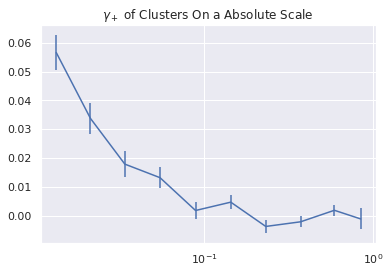

Aggregated xi:
[-16.1293 -17.3837 -15.1448 -18.5558  -3.8616 -16.7331  19.3056  14.7034
 -12.1256   2.1166]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1230.5974 -1983.8287 -2865.8346 -4090.8671 -5263.555  -6944.9176
 -7498.6252 -6742.9655 -3454.4574  -308.1356]
------------------------------------------------------------------------------
Aggregated npairs:
[ 285.  515.  847. 1409. 2176. 3582. 5130. 6831. 6566. 1836.]
------------------------------------------------------------------------------
Mean xi:
[-0.0566 -0.0338 -0.0179 -0.0132 -0.0018 -0.0047  0.0038  0.0022 -0.0018
  0.0012]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3179 -3.8521 -3.3835 -2.9034 -2.4189 -1.9388 -1.4617 -0.9871 -0.5261
 -0.1678]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

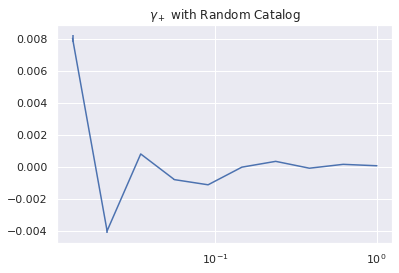

[ 8.0614e-03 -4.0169e-03  8.0985e-04 -8.0003e-04 -1.1234e-03 -1.6914e-05
  3.4635e-04 -8.3508e-05  1.5886e-04  6.9678e-05]
[-2.1244e-04  1.0585e-04 -2.1341e-05  2.1083e-05  2.9603e-05  4.4573e-07
 -9.1272e-06  2.2006e-06 -4.1863e-06 -1.8362e-06]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

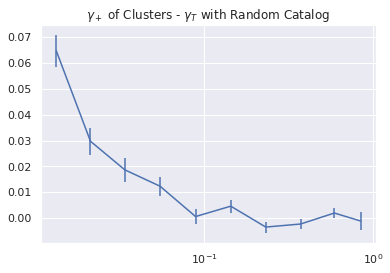

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

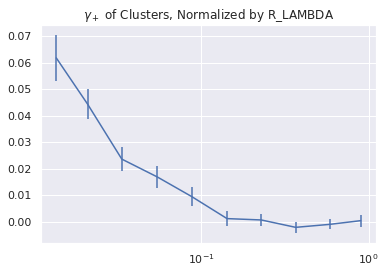

Aggregated xi:
[ -8.837  -17.2671 -15.8011 -18.8865 -16.3073  -3.4187  -3.026   12.4742
   6.8735  -2.1619]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -613.9686 -1502.8764 -2266.7101 -3240.4171 -4175.0669 -5464.0802
 -6313.4259 -6041.3671 -3854.9777  -538.9442]
------------------------------------------------------------------------------
Aggregated npairs:
[ 143.  389.  668. 1115. 1718. 2807. 4277. 6018. 7189. 4890.]
------------------------------------------------------------------------------
Mean xi:
[-0.0618 -0.0444 -0.0237 -0.0169 -0.0095 -0.0012 -0.0007  0.0021  0.001
 -0.0004]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2935 -3.8634 -3.3933 -2.9062 -2.4302 -1.9466 -1.4761 -1.0039 -0.5362
 -0.1102]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)